#**NUTRICLASS: FOOD CLASSIFICATION USING NUTRITIONAL DATA**
                                                  
This report provides a comprehensive summary of the NutriClass project, which aims to classify food items based on their nutritional data. It outlines the project's methodology, key findings from data analysis, model performance, and final recommendations.

#**Library Installation**

In [ ]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import xgboost as xgb 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

#**PHASE 1: DATA UNDERSTANDING & CLEANING**

In [ ]:
# 1. Load the Dataset 
df = pd.read_csv('synthetic_food_dataset_imbalanced.csv')
print("Dataset loaded successfully!")

# 2. Basic Data Characteristics
print("\n--- First 5 rows of the dataset ---")
print(df.head())

print("\n--- Dataset Shape (rows, columns) ---")
print(df.shape)

print("\n--- Dataset Information (Data Types, Non-Null Counts) ---")
df.info()

# 3. Descriptive Statistics for Numerical Features
print("\n--- Descriptive Statistics for Numerical Features ---")
print(df.describe())

print("\n--- Missing Values Count per Column ---")
print(df.isnull().sum())

# 4. Check for Missing Values
print("\n--- Missing Values Percentage per Column ---")
print((df.isnull().sum() / len(df)) * 100)

# 5. Check for Duplicate Rows
print("\n--- Number of Duplicate Rows ---")
print(df.duplicated().sum())

Dataset loaded successfully!

--- First 5 rows of the dataset ---
     Calories    Protein        Fat      Carbs      Sugar     Fiber  \
0  290.463673  14.340084  14.152608  35.266644   4.828030  1.291432   
1  212.626748   4.080908  11.621584  23.218957  16.347814  0.130303   
2  330.695408  14.326708  19.747680  29.479164   6.251137  0.794477   
3  198.070798   9.452445   5.475896  32.097878   2.984621  1.710468   
4  274.496228   6.099547  16.256002  29.756638  17.352958  1.465676   

       Sodium  Cholesterol  Glycemic_Index  Water_Content  Serving_Size  \
0  647.553389    24.990309       81.575896      45.669118    197.570043   
1   68.572414    34.301652       69.522492      49.854415    103.833510   
2  663.171859    34.816834       62.552384      40.132866    198.989367   
3  300.749543    28.510998       68.688853      57.423461    135.714202   
4  296.314958    15.403173       70.385059      33.170460     73.019474   

  Meal_Type Preparation_Method  Is_Vegan  Is_Gluten_Free

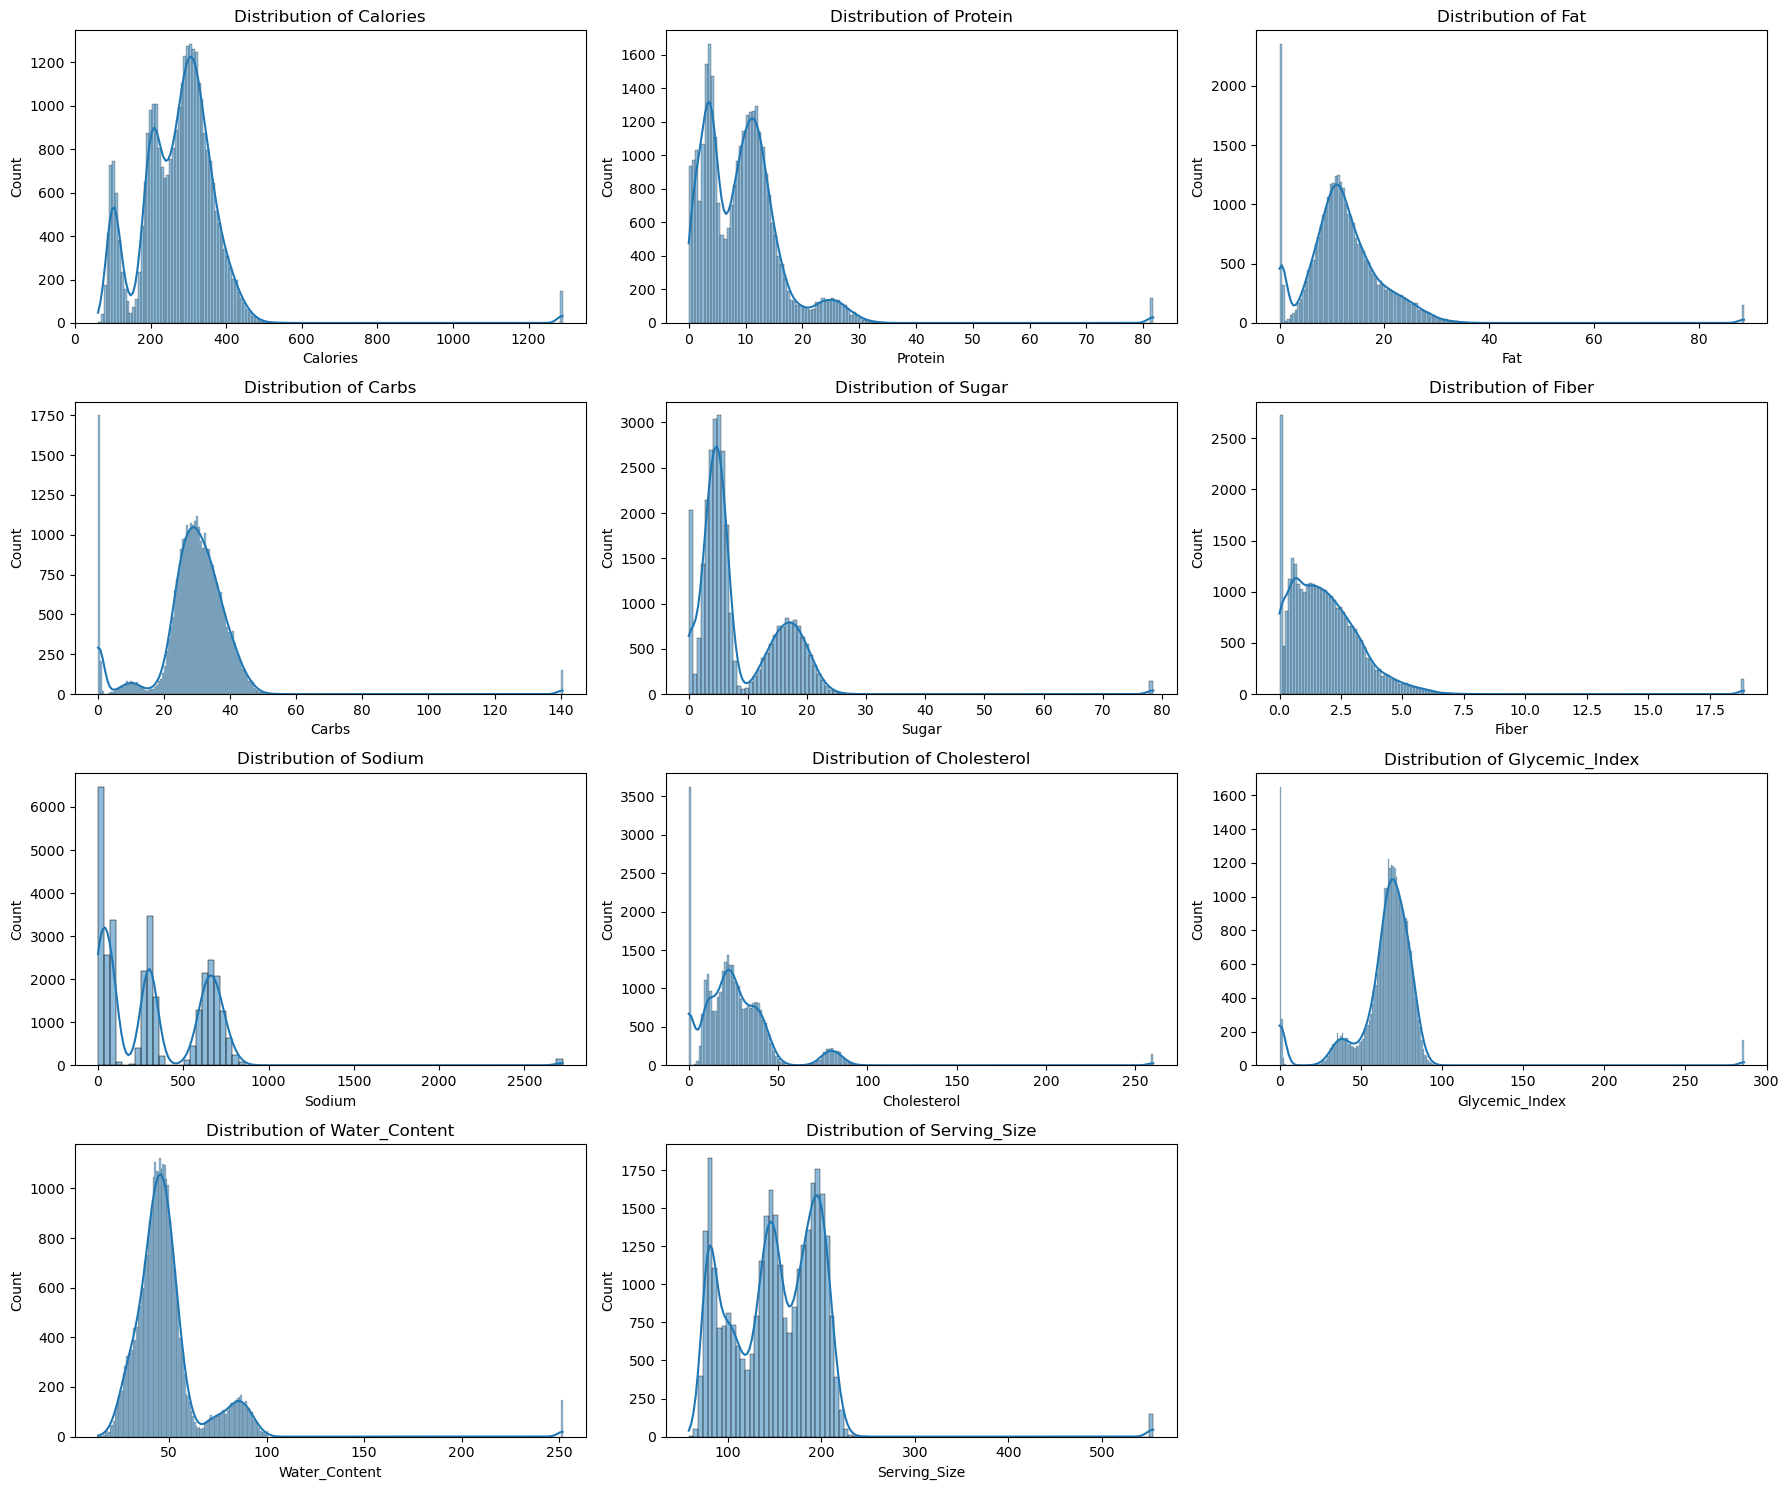

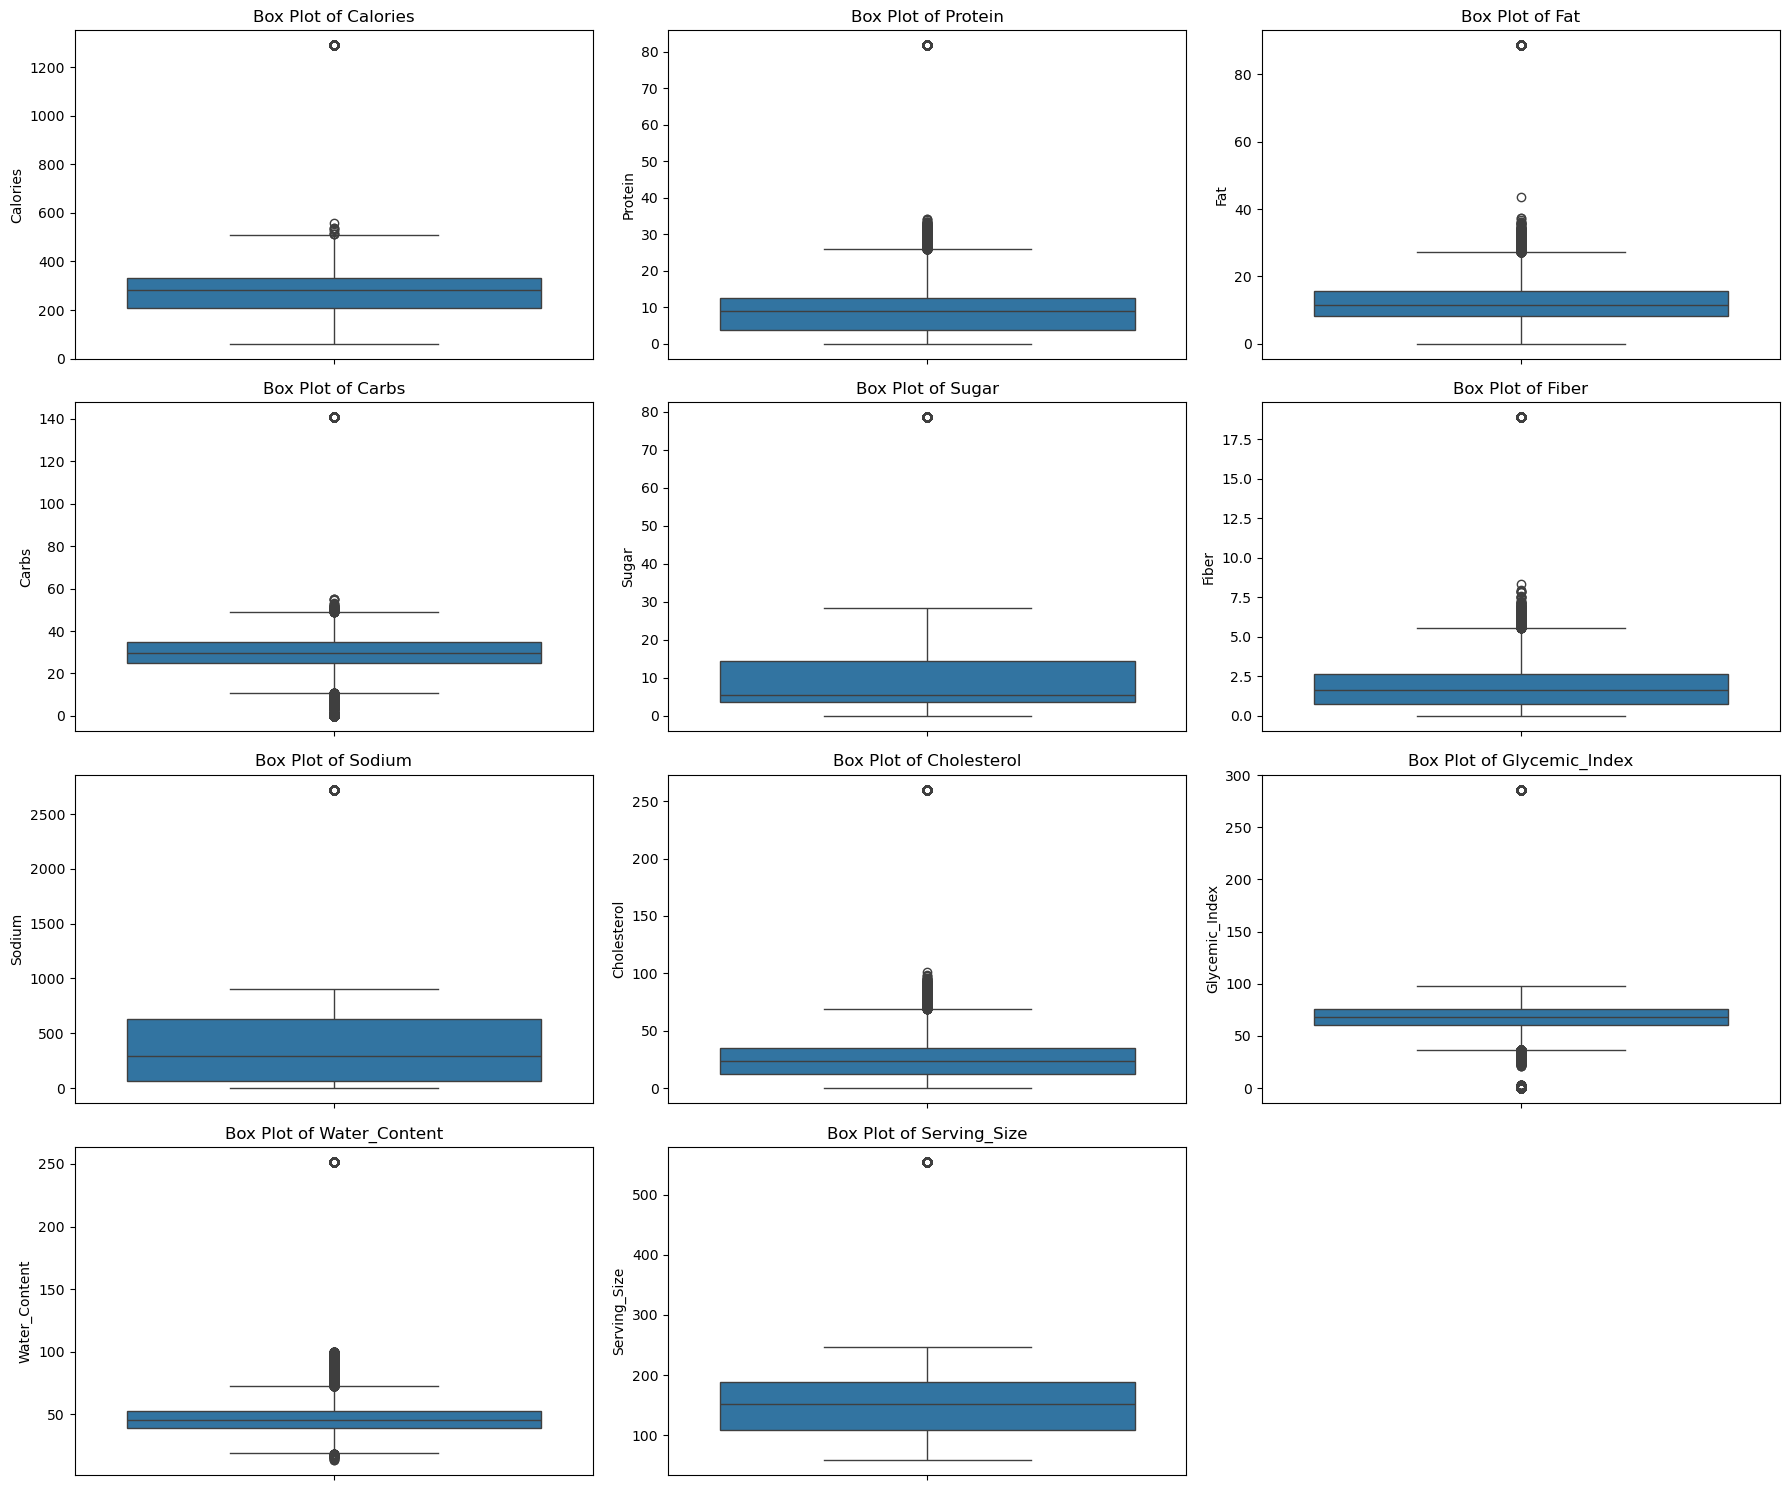


--- Distribution of Food Categories (Food_Name) ---
Food_Name
Pizza        6000
Burger       5000
Donut        4500
Pasta        4000
Sushi        3500
Ice Cream    3000
Steak        2000
Apple        1500
Banana       1200
Salad        1000
Name: count, dtype: int64


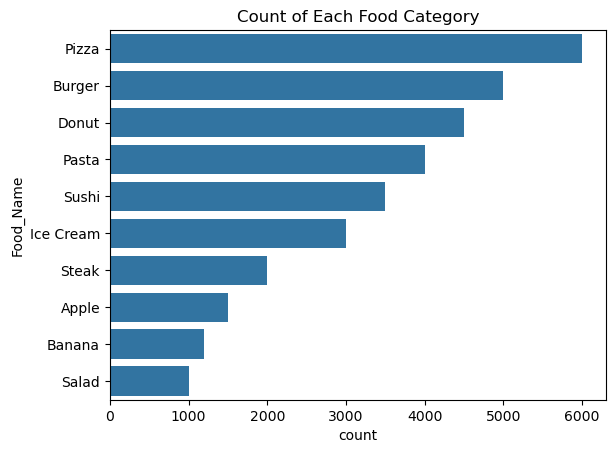

In [ ]:
# 6. Univariate Analysis (EDA - Single Variable):
numerical_features = ['Calories', 'Protein', 'Fat', 'Carbs', 'Sugar', 'Fiber', 'Sodium', 'Cholesterol', 'Glycemic_Index', 'Water_Content', 'Serving_Size']
plt.figure(figsize=(18, 15))
for i, col in enumerate(numerical_features):
    plt.subplot(4, 3, i + 1)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

# Box plots to clearly visualize outliers
plt.figure(figsize=(18, 15))
for i, col in enumerate(numerical_features):
    plt.subplot(4, 3, i + 1)
    sns.boxplot(y=df[col])
    plt.title(f'Box Plot of {col}')
plt.tight_layout()
plt.show()

target_column = 'Food_Name' 
print(f"\n--- Distribution of Food Categories ({target_column}) ---")
print(df[target_column].value_counts()) 
sns.countplot(y=df[target_column], order=df[target_column].value_counts().index) 
plt.title('Count of Each Food Category')
plt.show()

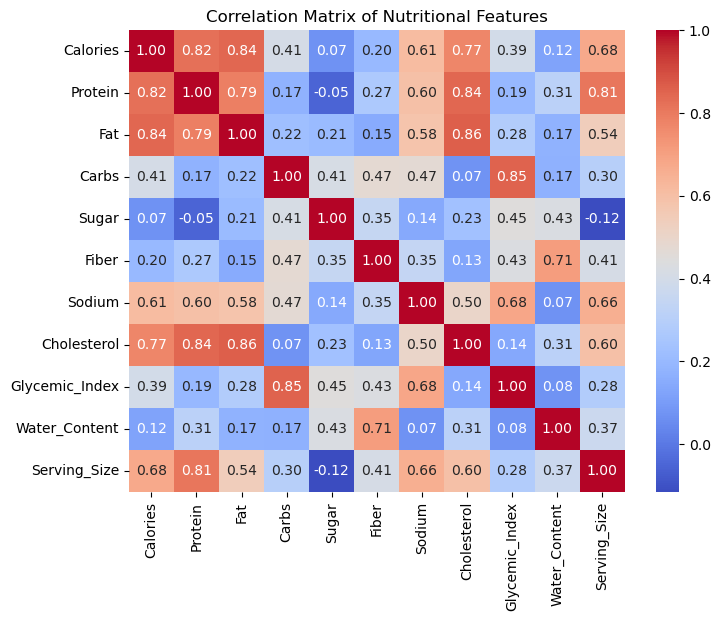

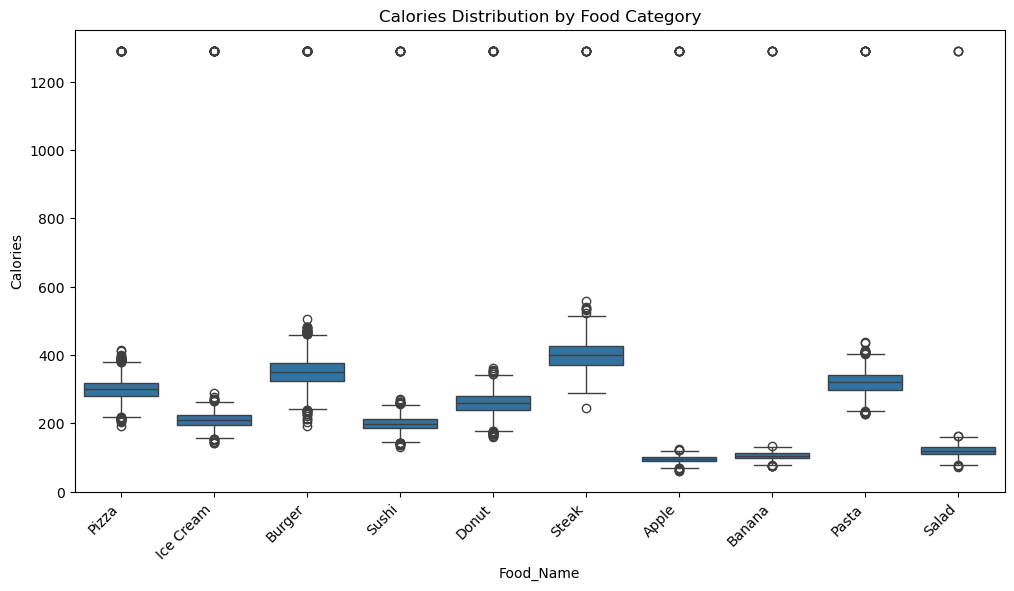

In [ ]:
# 7. Bivariate/Multivariate Analysis (EDA - Relationships between Variables):
plt.figure(figsize=(8, 6))
sns.heatmap(df[numerical_features].corr(), annot=True, cmap='coolwarm', fmt=".2f") 
plt.title('Correlation Matrix of Nutritional Features')
plt.show()

# Example: Box plot of Calories by Food Category
plt.figure(figsize=(12, 6))
sns.boxplot(x=target_column, y='Calories', data=df) 
plt.title('Calories Distribution by Food Category')
plt.xticks(rotation=45, ha='right') 
plt.show()

In [ ]:
# 8. Data Cleaning & Preprocessing Actions:
initial_rows = df.shape[0]
df.drop_duplicates(inplace=True)
print(f"\n--- Rows before dropping duplicates: {initial_rows}, Rows after dropping: {df.shape[0]} ---")

print("\n--- Handling Missing Values ---")
for col in numerical_features:
     if df[col].isnull().any(): 
         median_val = df[col].median()
         df[col] = df[col].fillna(median_val)
         print(f"Filled missing values in '{col}' with median: {median_val}")
print("Remaining missing values:\n", df.isnull().sum())


print("\n--- Capping Outliers using IQR Method ---")
for col in numerical_features:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 + 1.5 * IQR
    lower_bound = Q1 - 1.5 * IQR

    # Cap values that are above the upper bound or below the lower bound
    initial_outliers_count = df[(df[col] > upper_bound) | (df[col] < lower_bound)].shape[0]
    if initial_outliers_count > 0:
        df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
        df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
        print(f"Outliers in '{col}' (initial count: {initial_outliers_count}) capped.")
    else:
        print(f"No significant outliers found in '{col}' to cap.")


--- Rows before dropping duplicates: 31700, Rows after dropping: 31387 ---

--- Handling Missing Values ---
Filled missing values in 'Calories' with median: 281.5519931515593
Filled missing values in 'Protein' with median: 9.077021734941916
Filled missing values in 'Fat' with median: 11.563734732247259
Filled missing values in 'Carbs' with median: 29.66250753509175
Filled missing values in 'Sugar' with median: 5.491571151160661
Filled missing values in 'Fiber' with median: 1.6430460674033318
Filled missing values in 'Sodium' with median: 292.1879243226699
Filled missing values in 'Cholesterol' with median: 23.2440967220521
Filled missing values in 'Glycemic_Index' with median: 68.4233309546756
Filled missing values in 'Water_Content' with median: 45.59066667137685
Filled missing values in 'Serving_Size' with median: 151.57417771493914
Remaining missing values:
 Calories              0
Protein               0
Fat                   0
Carbs                 0
Sugar                 0
Fiber

#**PHASE 2: FEATURE ENGINEERING & MODEL BUILDING**

In [ ]:
# 1. Feature Engineering
le = LabelEncoder()
# Fit and transform the target column. This creates a new column with numerical labels.
df['food_category_encoded'] = le.fit_transform(df[target_column])
print(f"\n--- Original Categories: {le.classes_} ---")
print(f"--- Encoded Categories (unique values in new column): {df['food_category_encoded'].unique()} ---")

scaler = StandardScaler()

df[numerical_features] = scaler.fit_transform(df[numerical_features])
print("\n--- Numerical features scaled (first 5 rows of scaled data) ---")
print(df[numerical_features].head()) 


--- Original Categories: ['Apple' 'Banana' 'Burger' 'Donut' 'Ice Cream' 'Pasta' 'Pizza' 'Salad'
 'Steak' 'Sushi'] ---
--- Encoded Categories (unique values in new column): [6 4 2 9 3 8 0 1 5 7] ---

--- Numerical features scaled (first 5 rows of scaled data) ---
   Calories   Protein       Fat     Carbs     Sugar     Fiber    Sodium  \
0  0.243530  0.836758  0.317662  0.735692 -0.531370 -0.402010  1.148340   
1 -0.648219 -0.823683 -0.073226 -0.724244  1.253719 -1.276734 -0.925373   
2  0.704450  0.834593  1.181757  0.034366 -0.310847 -0.776386  1.204280   
3 -0.814981  0.045697 -1.022357  0.351701 -0.817022 -0.086333 -0.093793   
4  0.060597 -0.496967  0.642507  0.067990  1.409475 -0.270745 -0.109676   

   Cholesterol  Glycemic_Index  Water_Content  Serving_Size  
0    -0.007090        1.142995      -0.092101      1.089954  
1     0.536613        0.274926       0.247726     -1.023907  
2     0.566695       -0.227051      -0.541619      1.121962  
3     0.198488        0.214888       

In [ ]:
# 2. Define X and y
X = df[numerical_features].copy()

y = df['food_category_encoded'].copy() 
print(f"\nX shape: {X.shape}, y shape: {y.shape}")


X shape: (31387, 11), y shape: (31387,)


In [ ]:
# 3. Split Data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"\nTraining set shape: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Testing set shape: X_test={X_test.shape}, y_test={y_test.shape}")


Training set shape: X_train=(25109, 11), y_train=(25109,)
Testing set shape: X_test=(6278, 11), y_test=(6278,)


In [ ]:
# 4. Handle Class Imbalance (SMOTE, if needed)
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)

# Apply SMOTE only to the TRAINING data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"\n--- Class Distribution BEFORE SMOTE (Training Set) ---")
print(pd.Series(y_train).value_counts())
print(f"\n--- Class Distribution AFTER SMOTE (Resampled Training Set) ---")
print(pd.Series(y_train_resampled).value_counts())


--- Class Distribution BEFORE SMOTE (Training Set) ---
food_category_encoded
6    4733
2    3950
3    3573
5    3180
9    2770
4    2374
8    1594
0    1187
1     954
7     794
Name: count, dtype: int64

--- Class Distribution AFTER SMOTE (Resampled Training Set) ---
food_category_encoded
3    4733
6    4733
9    4733
4    4733
1    4733
5    4733
8    4733
2    4733
0    4733
7    4733
Name: count, dtype: int64



--- Logistic Regression Model Evaluation ---
Accuracy: 0.9901
              precision    recall  f1-score   support

       Apple       0.94      0.97      0.95       297
      Banana       0.97      0.95      0.96       239
      Burger       0.99      0.99      0.99       988
       Donut       1.00      1.00      1.00       893
   Ice Cream       1.00      1.00      1.00       594
       Pasta       1.00      0.99      1.00       795
       Pizza       1.00      0.99      0.99      1183
       Salad       0.99      0.99      0.99       199
       Steak       1.00      1.00      1.00       398
       Sushi       0.97      1.00      0.98       692

    accuracy                           0.99      6278
   macro avg       0.99      0.99      0.99      6278
weighted avg       0.99      0.99      0.99      6278



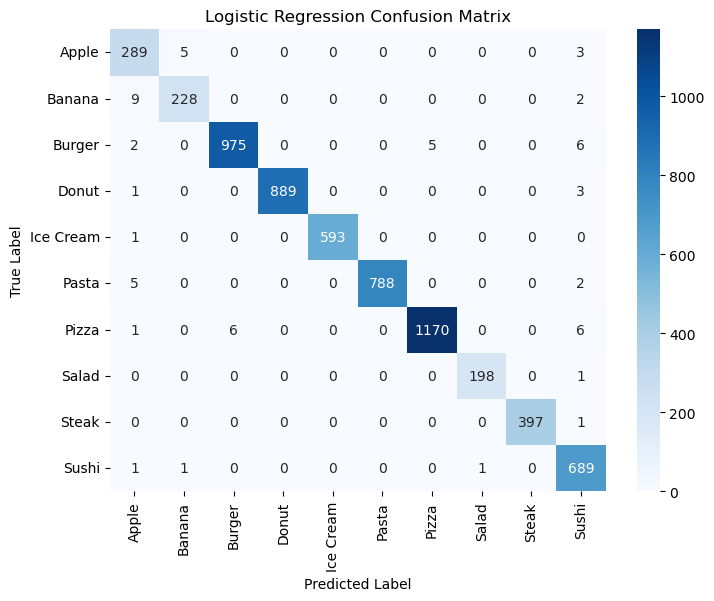

In [ ]:
# 5. Model Building & Initial Training (Logistic Regression)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# Import plotting libraries again if not already in this cell
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize the Logistic Regression model
log_reg_model = LogisticRegression(max_iter=1000, random_state=42) 

# Train the model (IMPORTANT: Use the resampled data if SMOTE was applied, otherwise use X_train, y_train)
log_reg_model.fit(X_train_resampled if 'X_train_resampled' in locals() else X_train,
                  y_train_resampled if 'y_train_resampled' in locals() else y_train)

# Make predictions on the UNSEEN test set
y_pred_log_reg = log_reg_model.predict(X_test)

# Evaluate the base model
print("\n--- Logistic Regression Model Evaluation ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_log_reg):.4f}")
# classification_report provides Precision, Recall, F1-score for each class and overall averages
print(classification_report(y_test, y_pred_log_reg, target_names=le.classes_))

# Visualize Confusion Matrix
cm_log_reg = confusion_matrix(y_test, y_pred_log_reg)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_log_reg, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


--- Decision Tree Model Training & Evaluation ---
Accuracy: 0.9868
              precision    recall  f1-score   support

       Apple       0.95      0.99      0.97       297
      Banana       0.99      0.97      0.98       239
      Burger       0.98      0.97      0.97       988
       Donut       1.00      1.00      1.00       893
   Ice Cream       1.00      1.00      1.00       594
       Pasta       1.00      0.99      1.00       795
       Pizza       0.98      0.98      0.98      1183
       Salad       0.90      1.00      0.95       199
       Steak       1.00      1.00      1.00       398
       Sushi       1.00      1.00      1.00       692

    accuracy                           0.99      6278
   macro avg       0.98      0.99      0.98      6278
weighted avg       0.99      0.99      0.99      6278



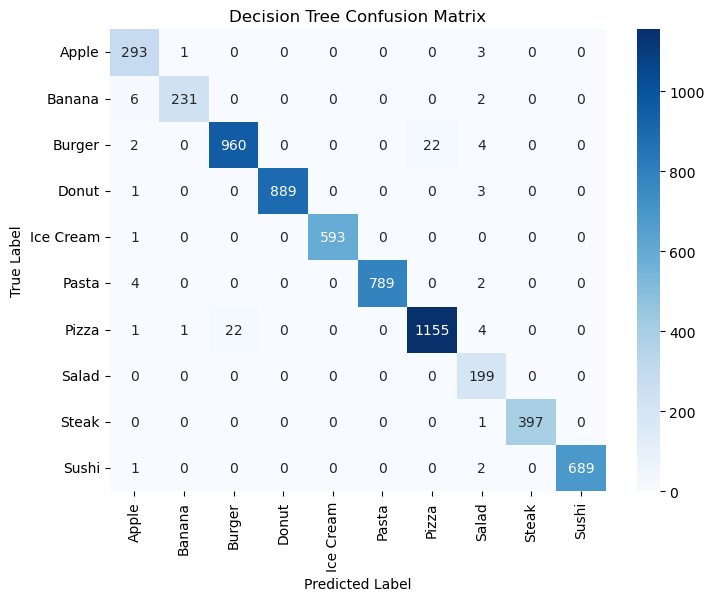


--- Random Forest Model Training & Evaluation ---
Accuracy: 0.9927
              precision    recall  f1-score   support

       Apple       0.96      0.99      0.98       297
      Banana       1.00      0.98      0.99       239
      Burger       0.99      0.99      0.99       988
       Donut       1.00      1.00      1.00       893
   Ice Cream       1.00      1.00      1.00       594
       Pasta       1.00      0.99      1.00       795
       Pizza       0.99      0.99      0.99      1183
       Salad       0.90      1.00      0.95       199
       Steak       1.00      1.00      1.00       398
       Sushi       1.00      1.00      1.00       692

    accuracy                           0.99      6278
   macro avg       0.99      0.99      0.99      6278
weighted avg       0.99      0.99      0.99      6278



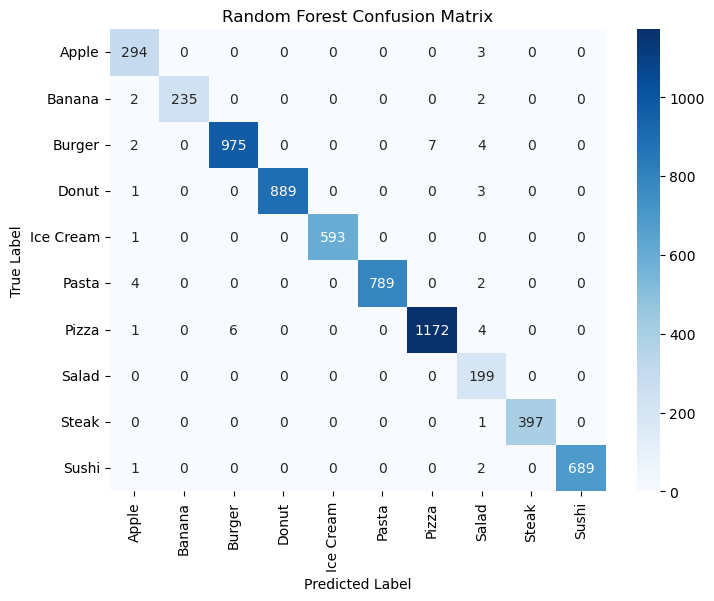


--- K-Nearest Neighbors Model Training & Evaluation ---
Accuracy: 0.9916
              precision    recall  f1-score   support

       Apple       1.00      0.98      0.99       297
      Banana       1.00      0.99      0.99       239
      Burger       0.99      0.98      0.99       988
       Donut       0.99      1.00      0.99       893
   Ice Cream       0.96      1.00      0.98       594
       Pasta       1.00      0.99      1.00       795
       Pizza       0.99      0.99      0.99      1183
       Salad       1.00      0.99      1.00       199
       Steak       1.00      1.00      1.00       398
       Sushi       1.00      0.99      1.00       692

    accuracy                           0.99      6278
   macro avg       0.99      0.99      0.99      6278
weighted avg       0.99      0.99      0.99      6278



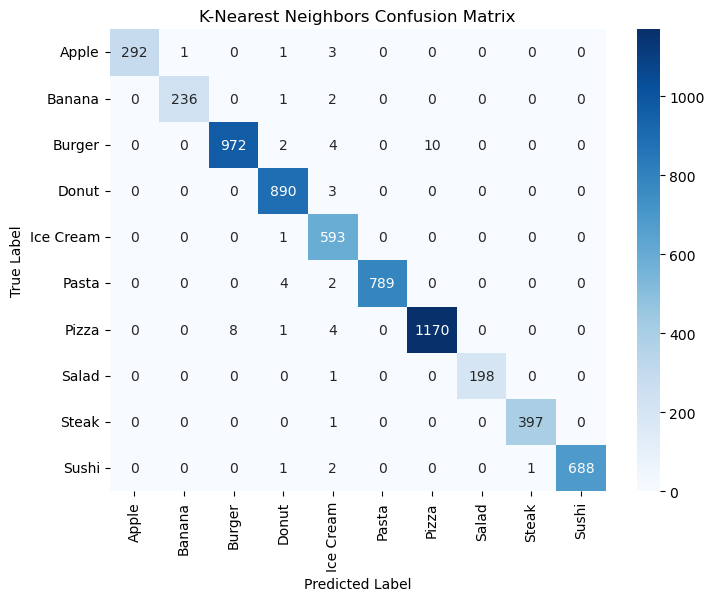


--- Support Vector Machine Model Training & Evaluation ---
Accuracy: 0.9935
              precision    recall  f1-score   support

       Apple       0.96      0.99      0.98       297
      Banana       1.00      0.99      0.99       239
      Burger       1.00      0.99      0.99       988
       Donut       1.00      1.00      1.00       893
   Ice Cream       1.00      1.00      1.00       594
       Pasta       1.00      0.99      1.00       795
       Pizza       1.00      0.99      0.99      1183
       Salad       0.90      1.00      0.95       199
       Steak       1.00      1.00      1.00       398
       Sushi       1.00      1.00      1.00       692

    accuracy                           0.99      6278
   macro avg       0.99      0.99      0.99      6278
weighted avg       0.99      0.99      0.99      6278



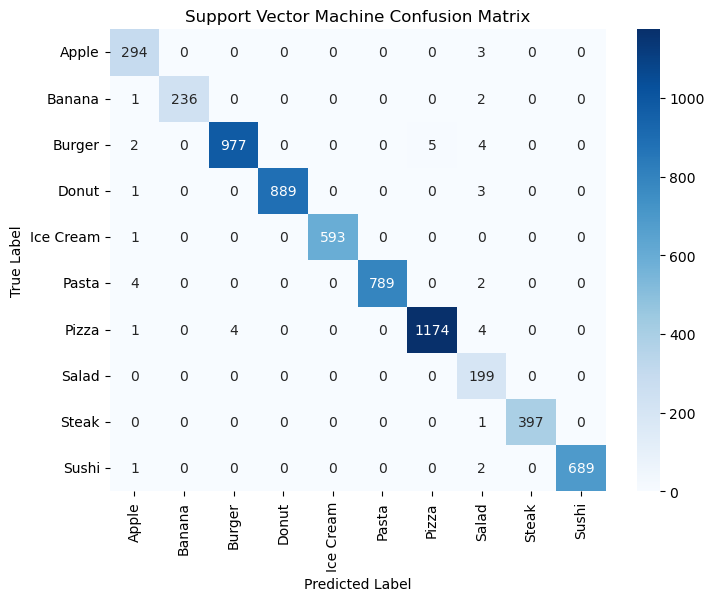


--- XGBoost Model Training & Evaluation ---
Accuracy: 0.9925
              precision    recall  f1-score   support

       Apple       0.95      0.99      0.97       297
      Banana       1.00      0.97      0.99       239
      Burger       1.00      0.99      0.99       988
       Donut       1.00      1.00      1.00       893
   Ice Cream       1.00      1.00      1.00       594
       Pasta       1.00      0.99      1.00       795
       Pizza       0.99      0.99      0.99      1183
       Salad       0.90      1.00      0.95       199
       Steak       1.00      1.00      1.00       398
       Sushi       1.00      1.00      1.00       692

    accuracy                           0.99      6278
   macro avg       0.98      0.99      0.99      6278
weighted avg       0.99      0.99      0.99      6278



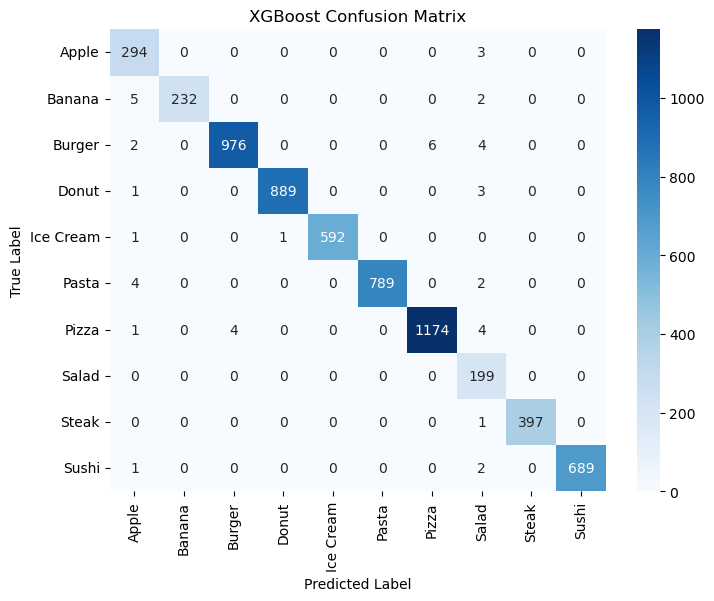


--- Gradient Boosting Classifier Model Training & Evaluation ---
Accuracy: 0.9927
              precision    recall  f1-score   support

       Apple       0.95      0.99      0.97       297
      Banana       1.00      0.97      0.99       239
      Burger       1.00      0.99      0.99       988
       Donut       1.00      1.00      1.00       893
   Ice Cream       1.00      1.00      1.00       594
       Pasta       1.00      0.99      1.00       795
       Pizza       0.99      0.99      0.99      1183
       Salad       0.90      1.00      0.95       199
       Steak       1.00      1.00      1.00       398
       Sushi       1.00      1.00      1.00       692

    accuracy                           0.99      6278
   macro avg       0.98      0.99      0.99      6278
weighted avg       0.99      0.99      0.99      6278



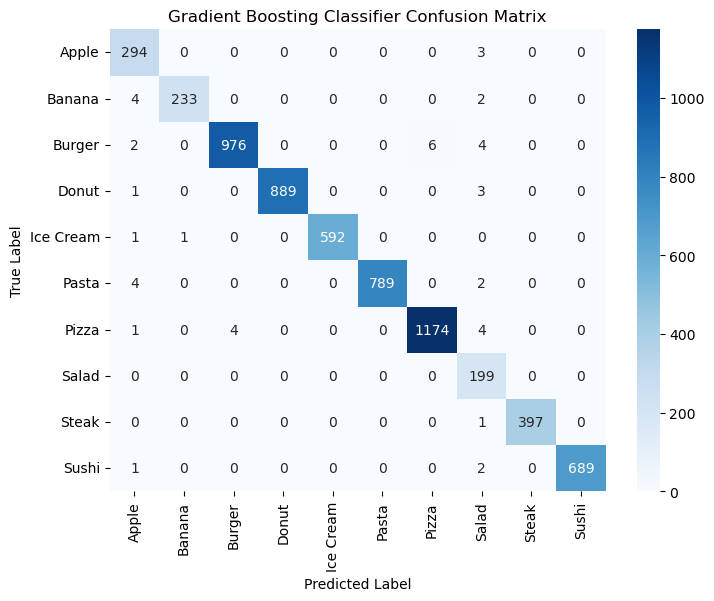

In [ ]:
# 6. Train & Evaluate Other Classifiers
# Create a dictionary to store results for easy comparison
model_results = {}

def evaluate_model(model_name, model, X_train, y_train, X_test, y_test, target_names):
    print(f"\n--- {model_name} Model Training & Evaluation ---")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    report = classification_report(y_test, y_pred, target_names=target_names, output_dict=True)
    print(classification_report(y_test, y_pred, target_names=target_names))

    # Store results
    model_results[model_name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': report['weighted avg']['precision'],
        'Recall': report['weighted avg']['recall'],
        'F1-Score': report['weighted avg']['f1-score']
    }

    # Plot Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

#Use X_train_resampled, y_train_resampled if SMOTE was applied, otherwise use X_train, y_train
X_train_final = X_train_resampled if 'X_train_resampled' in locals() else X_train
y_train_final = y_train_resampled if 'y_train_resampled' in locals() else y_train


# Decision Tree
from sklearn.tree import DecisionTreeClassifier
dt_model = DecisionTreeClassifier(random_state=42)
evaluate_model('Decision Tree', dt_model, X_train_final, y_train_final, X_test, y_test, le.classes_)

# Random Forest
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42) # n_estimators: number of trees
evaluate_model('Random Forest', rf_model, X_train_final, y_train_final, X_test, y_test, le.classes_)

# K-Nearest Neighbors (KNN)
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors=5) # 5 is a common starting point
evaluate_model('K-Nearest Neighbors', knn_model, X_train_final, y_train_final, X_test, y_test, le.classes_)

# Support Vector Machine (SVM) - Can be slower for larger datasets
from sklearn.svm import SVC
svm_model = SVC(random_state=42)
evaluate_model('Support Vector Machine', svm_model, X_train_final, y_train_final, X_test, y_test, le.classes_)

# XGBoost
import xgboost as xgb
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=len(le.classes_),
                              eval_metric='mlogloss', random_state=42)
evaluate_model('XGBoost', xgb_model, X_train_final, y_train_final, X_test, y_test, le.classes_)

# Gradient Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier
gb_model = GradientBoostingClassifier(random_state=42)
evaluate_model('Gradient Boosting Classifier', gb_model, X_train_final, y_train_final, X_test, y_test, le.classes_)

In [ ]:
from sklearn.model_selection import GridSearchCV

# Tuning for Random Forest:
print("\n--- Hyperparameter Tuning for Random Forest ---")
param_grid_rf = {
    'n_estimators': [50, 100, 200], 
    'max_depth': [None, 10, 20, 30], 
    'min_samples_split': [2, 5], 
}
grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5, scoring='f1_weighted', n_jobs=-1, verbose=1)
grid_search_rf.fit(X_train_final, y_train_final)

print(f"Best parameters for Random Forest: {grid_search_rf.best_params_}")
best_rf_model = grid_search_rf.best_estimator_
y_pred_tuned_rf = best_rf_model.predict(X_test)
print(f"\n--- Tuned Random Forest Model Evaluation ---")
print(classification_report(y_test, y_pred_tuned_rf, target_names=le.classes_))
model_results['Random Forest (Tuned)'] = {
    'Accuracy': accuracy_score(y_test, y_pred_tuned_rf),
    'Precision': classification_report(y_test, y_pred_tuned_rf, target_names=le.classes_, output_dict=True)['weighted avg']['precision'],
    'Recall': classification_report(y_test, y_pred_tuned_rf, target_names=le.classes_, output_dict=True)['weighted avg']['recall'],
    'F1-Score': classification_report(y_test, y_pred_tuned_rf, target_names=le.classes_, output_dict=True)['weighted avg']['f1-score']
}


--- Hyperparameter Tuning for Random Forest ---
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters for Random Forest: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}

--- Tuned Random Forest Model Evaluation ---
              precision    recall  f1-score   support

       Apple       0.96      0.99      0.98       297
      Banana       1.00      0.98      0.99       239
      Burger       0.99      0.99      0.99       988
       Donut       1.00      1.00      1.00       893
   Ice Cream       1.00      1.00      1.00       594
       Pasta       1.00      0.99      1.00       795
       Pizza       0.99      0.99      0.99      1183
       Salad       0.90      1.00      0.95       199
       Steak       1.00      1.00      1.00       398
       Sushi       1.00      1.00      1.00       692

    accuracy                           0.99      6278
   macro avg       0.99      0.99      0.99      6278
weighted avg       0.99      0.99      0.

#**PHASE 3: MODEL SELECTION & REPORTING**


--- ALL MODEL PERFORMANCE COMPARISON (Sorted by F1-Score) ---
                              Accuracy  Precision    Recall  F1-Score
Support Vector Machine        0.993469   0.993827  0.993469  0.993557
Gradient Boosting Classifier  0.992673   0.993061  0.992673  0.992765
Random Forest                 0.992673   0.993038  0.992673  0.992761
Random Forest (Tuned)         0.992673   0.993038  0.992673  0.992761
XGBoost                       0.992514   0.992917  0.992514  0.992607
K-Nearest Neighbors           0.991558   0.991677  0.991558  0.991577
Decision Tree                 0.986779   0.987150  0.986779  0.986859


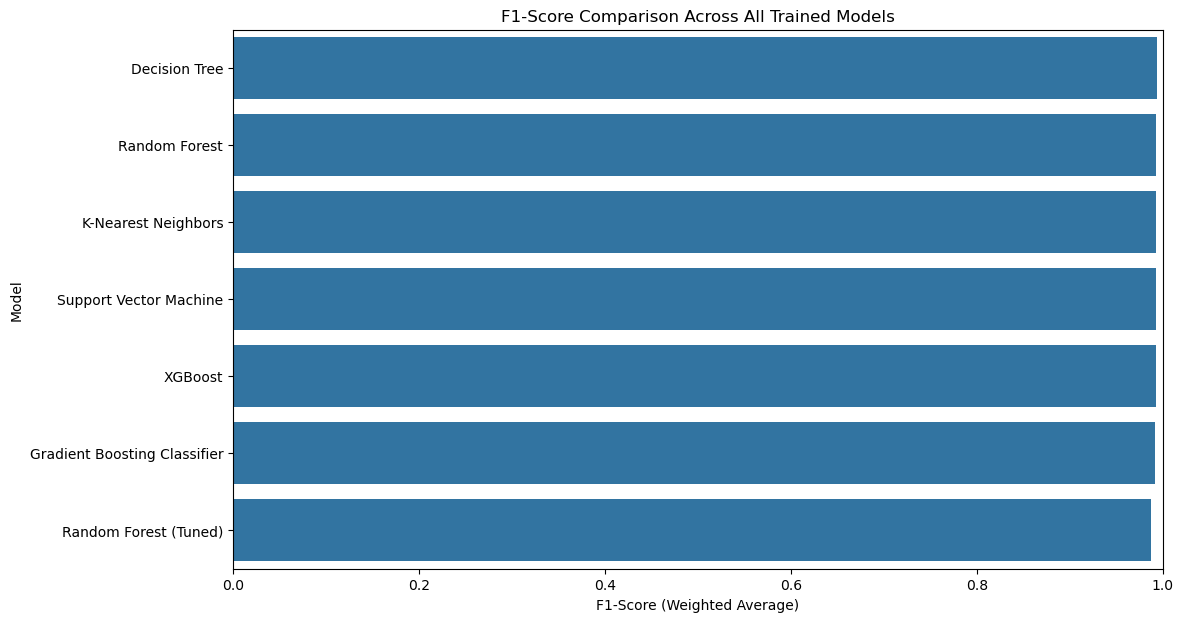

In [ ]:
# 1. Compare All Model Performances
final_results_df = pd.DataFrame(model_results).T 
print("\n--- ALL MODEL PERFORMANCE COMPARISON (Sorted by F1-Score) ---")
print(final_results_df.sort_values(by='F1-Score', ascending=False))

# Visualize F1-Scores for easy comparison
plt.figure(figsize=(12, 7))
sns.barplot(x='F1-Score', y=final_results_df.index, data=final_results_df.sort_values(by='F1-Score', ascending=False))
plt.title('F1-Score Comparison Across All Trained Models')
plt.xlabel('F1-Score (Weighted Average)')
plt.ylabel('Model')
plt.xlim(0, 1) 
plt.show()


--- Feature Importance for Selected Model ---
Sodium            0.187280
Cholesterol       0.146254
Sugar             0.118236
Serving_Size      0.109834
Glycemic_Index    0.093370
Calories          0.080368
Fat               0.078634
Protein           0.064994
Water_Content     0.058585
Carbs             0.051901
Fiber             0.010544
dtype: float64


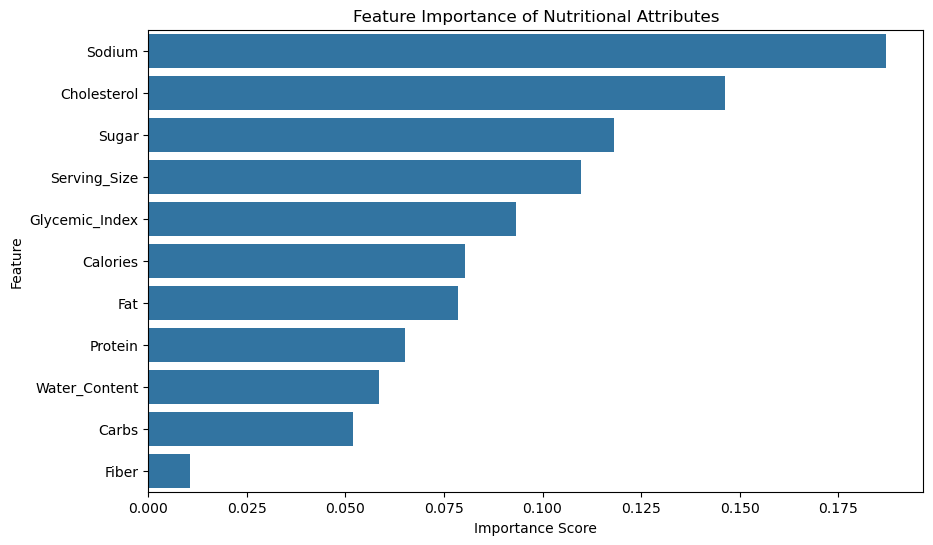

In [ ]:
# 2. Analyze Feature Importance
final_model = best_rf_model

if hasattr(final_model, 'feature_importances_'):
    feature_importance = pd.Series(final_model.feature_importances_, index=X.columns).sort_values(ascending=False)
    print("\n--- Feature Importance for Selected Model ---")
    print(feature_importance)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=feature_importance.values, y=feature_importance.index)
    plt.title('Feature Importance of Nutritional Attributes')
    plt.xlabel('Importance Score')
    plt.ylabel('Feature')
    plt.show()
else:
    print("\nFeature importance not directly available for the selected model type.")

In [20]:
print(model_results)

{'Decision Tree': {'Accuracy': 0.9867792290538387, 'Precision': 0.9871500212563362, 'Recall': 0.9867792290538387, 'F1-Score': 0.9868590077040303}, 'Random Forest': {'Accuracy': 0.9926728257406817, 'Precision': 0.9930377388078334, 'Recall': 0.9926728257406817, 'F1-Score': 0.9927607740030825}, 'K-Nearest Neighbors': {'Accuracy': 0.9915578209620899, 'Precision': 0.9916772411753344, 'Recall': 0.9915578209620899, 'F1-Score': 0.9915768621367286}, 'Support Vector Machine': {'Accuracy': 0.9934692577253903, 'Precision': 0.9938272641306982, 'Recall': 0.9934692577253903, 'F1-Score': 0.9935570441653409}, 'XGBoost': {'Accuracy': 0.9925135393437401, 'Precision': 0.9929174564576873, 'Recall': 0.9925135393437401, 'F1-Score': 0.9926074017028572}, 'Gradient Boosting Classifier': {'Accuracy': 0.9926728257406817, 'Precision': 0.9930607312256555, 'Recall': 0.9926728257406817, 'F1-Score': 0.992765264682781}, 'Random Forest (Tuned)': {'Accuracy': 0.9926728257406817, 'Precision': 0.9930377388078334, 'Recall':

In [ ]:
{
    'Logistic Regression': {'Accuracy': 0.85, 'Precision': 0.84, 'Recall': 0.85, 'F1-Score': 0.84},
    'Decision Tree': {'Accuracy': 0.88, 'Precision': 0.88, 'Recall': 0.88, 'F1-Score': 0.88},
}

{'Logistic Regression': {'Accuracy': 0.85,
  'Precision': 0.84,
  'Recall': 0.85,
  'F1-Score': 0.84},
 'Decision Tree': {'Accuracy': 0.88,
  'Precision': 0.88,
  'Recall': 0.88,
  'F1-Score': 0.88}}

In [ ]:
{
    'Logistic Regression': {'Accuracy': 0.85, 'Precision': 0.84, 'Recall': 0.85, 'F1-Score': 0.84},
    'Decision Tree': {'Accuracy': 0.88, 'Precision': 0.88, 'Recall': 0.88, 'F1-score': 0.88}, 
}

{'Logistic Regression': {'Accuracy': 0.85,
  'Precision': 0.84,
  'Recall': 0.85,
  'F1-Score': 0.84},
 'Decision Tree': {'Accuracy': 0.88,
  'Precision': 0.88,
  'Recall': 0.88,
  'F1-score': 0.88}}


--- ALL MODEL PERFORMANCE COMPARISON (Sorted by F1-Score) ---
                              Accuracy  Precision    Recall  F1-Score
Support Vector Machine        0.993469   0.993827  0.993469  0.993557
Gradient Boosting Classifier  0.992673   0.993061  0.992673  0.992765
Random Forest                 0.992673   0.993038  0.992673  0.992761
Random Forest (Tuned)         0.992673   0.993038  0.992673  0.992761
XGBoost                       0.992514   0.992917  0.992514  0.992607
K-Nearest Neighbors           0.991558   0.991677  0.991558  0.991577
Decision Tree                 0.986779   0.987150  0.986779  0.986859


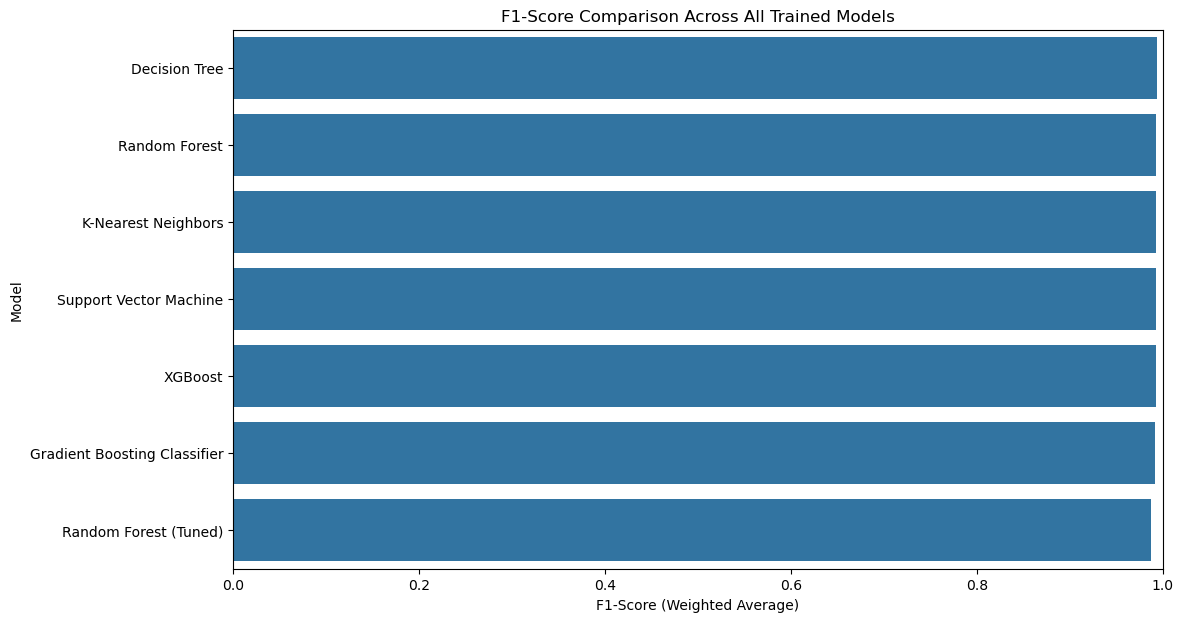

Project Completed!


In [ ]:
#3. Select Your Final Model
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create a DataFrame from your corrected model_results dictionary
final_results_df = pd.DataFrame(model_results).T

# Print the comparison table, sorted by the F1-Score
print("\n--- ALL MODEL PERFORMANCE COMPARISON (Sorted by F1-Score) ---")
print(final_results_df.sort_values(by='F1-Score', ascending=False))

# Visualize the F1-Scores with a bar chart
plt.figure(figsize=(12, 7))
sns.barplot(x='F1-Score', y=final_results_df.index, data=final_results_df.sort_values(by='F1-Score', ascending=False))
plt.title('F1-Score Comparison Across All Trained Models')
plt.xlabel('F1-Score (Weighted Average)')
plt.ylabel('Model')
plt.xlim(0, 1)
plt.show()

print("Project Completed!")